In [2]:
import sys
import os
parent_dir = os.path.abspath('..')
sys.path.append(parent_dir)
import um_dynamics.dynamics as u2d
import um_dynamics.utils.transformation_matrix as Tf
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

In [3]:
alpha = u2d.RobotDynamics()
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
path_to_urdf = os.path.join(
    project_root,
    'usage',
    'urdf',
    'alpha_5_robot.urdf'
)
alpha.from_file(path_to_urdf)
root = "base_link"
tip = "alpha_standard_jaws_base_link"
kinematic_dict, K, P, L, D, C, g, qdd, joint_torque = alpha.build_model(root, tip, floating_base=True)

joint_min = np.array([1.00, 0.01, 0.01, 0.01])
joint_max = np.array([5.50, 3.40, 3.40, 5.70])
base_T0 = [0.190, 0.000, -0.120, 3.142, 0.000, 0.000] # underarm 
base_T1 = [0.0, 0.000, 0.0, 0.0, 0.000, 0.000] # overarm
n_joints = alpha.get_n_joints(root, tip)

In [4]:
kinematic_dict = alpha.get_kinematic_dict
inertial_origins_params, m_params, I_params, vec_g, q, q_dot, q_dotdot, tau, base_pose, world_pose = kinematic_dict['parameters']

In [5]:
R_f = ca.Function("R_f", [q, base_pose, world_pose], [ kinematic_dict['R_symx'][-1]]) # rotation matrix
fk_eval = ca.Function("fkeval", [q, base_pose, world_pose], [kinematic_dict['qFks'][-1]]) # forward kinematics in quaternion form
body_J_eval = ca.Function("body_J_eval", [q, base_pose, world_pose], [kinematic_dict['body_J'][-1]]) # body Jacobian
geo_J_eval = ca.Function("geo_J_eval", [q, base_pose, world_pose], [kinematic_dict['geo_J'][-1]]) # geometric Jacobian
anlyt_J_eval = ca.Function("anlyt_J_eval", [q, base_pose, world_pose], [kinematic_dict['anlyt_J'][-1]]) # analytical Jacobian

In [6]:
def verify_geometric_jacobian(
        q,           # joint‑angle vector    (iterable of scalars)
        q_dot,             # joint‑rate vector    (iterable of scalars)
        base_T,            # point of manipulator base attachment wrt to floating origin
        p_n,           # world pose
        *, 
        epsilon  = 1e-6,   # finite‑difference step
        frame    = "spatial",  # "spatial" | "body"
        verbose  = True,
):
    # make CasADi vectors
    q  = ca.vertcat(q)
    q_dot  = ca.vertcat(q_dot)
    p_n = ca.vertcat(p_n)

    # ------------------------------------------------------------------
    # Forward kinematics at   n ± ε q̇
    # ------------------------------------------------------------------
    pose_p = fk_eval(q + epsilon*q_dot, base_T, p_n)     # 6×1 (xyz+rp y)
    pose_m = fk_eval(q - epsilon*q_dot, base_T, p_n)
    p_p, p_m = pose_p[:3], pose_m[:3]               # positions

    # central‑difference linear velocity in spatial frame
    v_linear_fd = (p_p - p_m) / (2*epsilon)

    # rotations at the two configs
    R1 = R_f(q,p_n, base_T)             # R(q)
    R2 = R_f(q + epsilon*q_dot, base_T, p_n)             # R(q + ε q̇)

    # body‑frame angular velocity from R⁻¹ dR/dt ≈ log(R_rel)/(2ε)
    R_rel        = R1.T @ R2
    omega_body_fd = Tf.vee((R_rel - R_rel.T) / (2*epsilon))

    # convert to spatial if required
    omega_spatial_fd = R1 @ omega_body_fd

    # ------------------------------------------------------------------
    # Jacobian prediction
    # ------------------------------------------------------------------
    Jg = geo_J_eval(q, base_T, p_n)     # spatial Jacobian (6×n)
    Jb = body_J_eval(q, base_T, p_n)     # body    Jacobian (6×n)

    if frame.lower() == "spatial":
        twist_pred = Jg @ q_dot
        v_pred     = twist_pred[:3]
        w_pred     = twist_pred[3:]
        v_err      = float(ca.norm_2(v_linear_fd     - v_pred))
        w_err      = float(ca.norm_2(omega_spatial_fd - w_pred))

    elif frame.lower() == "body":
        twist_pred = Jb @ q_dot
        v_pred     = twist_pred[:3]
        w_pred     = twist_pred[3:]
        v_err      = float(ca.norm_2(v_linear_fd - v_pred))
        w_err      = float(ca.norm_2(omega_body_fd      - w_pred))

    else:
        raise ValueError("frame must be 'spatial' or 'body'")

    # ------------------------------------------------------------------
    # diagnostics
    # ------------------------------------------------------------------
    if verbose:
        print(f"Frame: {frame}")
        print("v_fd  :",   np.array(v_linear_fd.full().squeeze()))
        print("v_pred:",   np.array(v_pred.full().squeeze()))
        print("ω_fd  :",   np.array((omega_spatial_fd if frame=='spatial' else omega_body_fd).full().squeeze()))
        print("ω_pred:",   np.array(w_pred.full().squeeze()))
        print("‖Δv‖  :", v_err)
        print("‖Δω‖  :", w_err)

    return v_err, w_err


In [7]:
v_err, w_err = verify_geometric_jacobian(
    q      = [ca.pi, ca.pi, ca.pi, ca.pi],
    q_dot  = [0.5,0.5,0.7,0.5],
    base_T = base_T0,
    p_n    = [0.0, 1.0, 0, 0, 0, 0],
    frame  = "spatial"
)
assert v_err < 1e-6 and w_err < 1e-6, "Jacobian check failed"


Frame: spatial
v_fd  : [-4.61000266e-02 -1.00230935e-05  2.39999979e-02]
v_pred: [-4.61000265e-02 -1.00228984e-05  2.39999979e-02]
ω_fd  : [-1.85751284e-06 -1.99592637e-01 -1.00008139e+00]
ω_pred: [-1.85751286e-06 -1.99592637e-01 -1.00008139e+00]
‖Δv‖  : 2.0581318215508254e-10
‖Δω‖  : 2.0138110647502177e-10


In [8]:
min_pos_fb, max_pos_fb, positions_fb = alpha.approximate_workspace(root, tip,list(zip(joint_min, joint_max)), base_T0, floating_base=True, num_samples=15000)
min_pos_fx, max_pos_fx, positions_fx = alpha.approximate_workspace(root, tip,list(zip(joint_min, joint_max)), base_T1, floating_base=False, num_samples=15000)
np.save("workspace.npy", positions_fb)
workspace_points = np.load("workspace.npy")

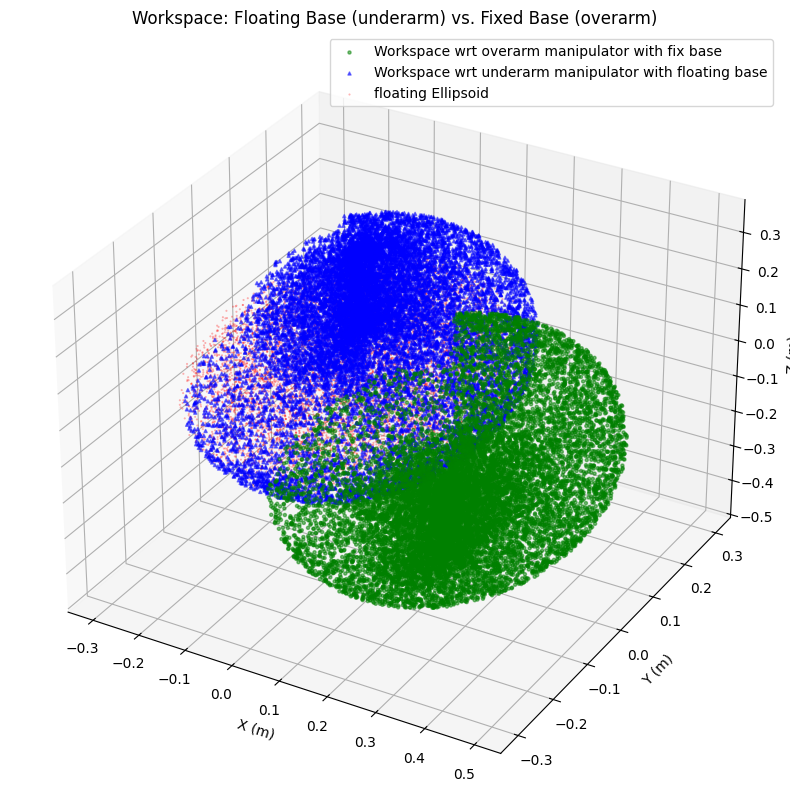

In [12]:
def generate_rov_ellipsoid(a=0.5, b=0.3, c=0.2, num_points=10000):
    points = []
    while len(points) < num_points:
        pt = np.random.uniform(-1, 1, 3)
        if (pt[0]/a)**2 + (pt[1]/b)**2 + (pt[2]/c)**2 <= 1:
            points.append(pt)
    return points

rov_ellipsoid_cl_pts = generate_rov_ellipsoid(a=0.3, b=0.3, c=0.2, num_points=10000) #vehicle cloudpoints

def plot_floating_vs_fixed(
    positions_fb,
    positions_fx,
    extra_pts=None
):
    """
    Plots both floating-base and fixed-base workspaces in the same frame,
    with distinct colors for better visual separation. Also optionally plots
    an extra set of points (e.g., ROV ellipsoid) if provided.
    """

    # Plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(projection='3d')

    # Floating-base workspace: wrt BlueROV CoM
    ax.scatter(
        positions_fb[:, 0], positions_fb[:, 1], positions_fb[:, 2],
        c='green', marker='o', s=5, alpha=0.5,
        label='Workspace wrt overarm manipulator with fix base'
    )

    # Fixed-base workspace: wrt Reach Alpha base link (shifted)
    ax.scatter(
        positions_fx[:, 0], positions_fx[:, 1], positions_fx[:, 2],
        c='blue', marker='^', s=5, alpha=0.5,
        label='Workspace wrt underarm manipulator with floating base'
    )

    # Plot extra points if provided (e.g., floating ellipsoid)
    if extra_pts is not None:
        extra_pts = np.array(extra_pts)
        ax.scatter(
            extra_pts[:, 0], extra_pts[:, 1], extra_pts[:, 2],
            c='red', marker='.', s=1, alpha=0.3,
            label='floating Ellipsoid'
        )

    ax.set_title("Workspace: Floating Base (underarm) vs. Fixed Base (overarm)")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.legend()
    plt.show()
    
plot_floating_vs_fixed(
    positions_fb,
    positions_fx,
    extra_pts=rov_ellipsoid_cl_pts
)

In [10]:
# Precompute convex hull from your workspace points (positions_fb: (N x 3) array)
workspace_hull = ConvexHull(workspace_points)
vehicle_body_hull = ConvexHull(rov_ellipsoid_cl_pts)

def is_endeffector_point_workspace_valid(point):
    """
    Returns True if 'point' is in the workspace hull but *not* in the vehicle hull.
    Equivalently, we want:  point ∈ (Workspace \ Vehicle) = Workspace ∩ (Vehicle)^c
    """
    inside_workspace = np.all(
        np.dot(workspace_hull.equations[:, :-1], point) + workspace_hull.equations[:, -1] <= 0
    )
    inside_vehicle = np.all(
        np.dot(vehicle_body_hull.equations[:, :-1], point) + vehicle_body_hull.equations[:, -1] <= 0
    )
    # accept the point if it is inside the workspace and *not* inside the vehicle hull.
    return inside_workspace and not inside_vehicle

In [11]:
task_point = np.array([0.31396762,  0.00519786, -0.21436635])  # Example target position

if is_endeffector_point_workspace_valid(task_point):
    print("Task is within the workspace.")
else:
    print("Task is out-of-workspace.")

Task is within the workspace.
